# PyFME Validation: comparing response versus Matlab model

In [54]:
from pyfme.aircrafts import Cessna172, SimplifiedCessna172
from pyfme.models import EulerFlatEarth
import numpy as np
# nl = np.linalg
import matplotlib.pyplot as plt
from pyfme.environment.atmosphere import SeaLevel
from pyfme.environment.wind import NoWind
from pyfme.environment.gravity import VerticalConstant
from pyfme.environment import Environment
# from pyfme.utils.trimmer import steady_state_trim
from pyfme.simulator import Simulation
from pyfme.utils.export import results2matlab
from scipy.io import savemat, loadmat
from pyfme.utils.coordinates import wind2body, body2wind
from pyfme.utils.input_generator import Constant, Doublet, Ramp
from json import load as jload
from copy import deepcopy as cp
plt.style.use('ggplot')
from scipy.interpolate import interp1d as itp
import pickle
import pandas as pd

In [55]:
%matplotlib inline

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running a PyFME simulation and save it to a MATLAB readable file

We start by defining the airplane and the environment.

In [57]:
aircraft = SimplifiedCessna172()

In [58]:
aircraft.control_limits

{'delta_aileron': (-0.26179938779914941, 0.3490658503988659),
 'delta_elevator': (-0.4537856055185257, 0.48869219055841229),
 'delta_rudder': (-0.27925268031909273, 0.27925268031909273),
 'delta_throttle': (0, 1)}

In [59]:
atmosphere = SeaLevel()
gravity = VerticalConstant()
wind = NoWind()
environment = Environment(atmosphere, gravity, wind)

Generate a serie of states on which to test

In [60]:
from pyfme.models import EulerFlatEarthState

In [61]:
state = EulerFlatEarthState(from_json='0.json')

In [62]:
system = EulerFlatEarth(aircraft, environment)

In [63]:
cont = {'delta_aileron': -3.5358951610137923e-14,
 'delta_elevator': -0.062874614281044197,
 'delta_rudder': 2.1771806804482197e-13,
 'delta_throttle': 0.83029313409410466}
controls = {
    'delta_elevator': Doublet(t_init=2, T=1, A=0.1, offset=cont['delta_elevator']),
    'delta_aileron': Ramp(t_init=1,T=2, A=.2, offset=cont['delta_aileron']),
    'delta_rudder': Constant(cont['delta_rudder']),
    'delta_throttle': Constant(cont['delta_throttle'])
}

In [64]:
# controls={"delta_throttle":Constant(.8), "delta_elevator":Constant(0), "delta_aileron":Constant(0), "delta_rudder":Constant(0)}

In [65]:
sol = system.integrate(3, state, controls)

In [13]:
# with open('batch_results.pkl','wb') as f:
#     pickle.dump(file=f,obj=results)
r = pickle.load(open('batch_results.pkl','rb'))

In [14]:
from pyfme.aircrafts.legacy import SimplifiedCessna1720

In [15]:
comp = SimplifiedCessna1720()

In [16]:
from pyfme.aircrafts.aircraft import ConventionalControls as cc
from pyfme.models.euler_flat_earth import EulerFlatEarthState as es

In [17]:
tr = r[0]

In [18]:
for i in range(1):
    state = es()
    for k in system.info:
        setattr(state, k, tr[k].iloc[i])

In [34]:
cont_test = cc()
for k,c in cont.items():
    setattr(cont_test, k, c)

In [23]:
cont2 = {'delta_aileron': -3.5358951610137923e-14,
 'delta_elevator': -0.062874614281044197,
 'delta_rudder': 2.1771806804482197e-13,
 'delta_t': 0.83029313409410466}

In [74]:
comp.calculate_forces_and_moments(state, environment, cont2)

[ -562.00158249  3867.9464067    317.65032811]


(array([-6215.70369259,  -868.60624158,  -586.34327295]),
 array([ -562.00158249,  3867.9464067 ,   317.65032811]))

In [73]:
# for t in tr.index():
aircraft.calculate_forces_and_moments(state, environment, cont_test)

[ -562.00158249  3867.9464067    317.65032811]


(array([-6215.70369259,  -868.60624158,  -586.34327295]),
 array([ -562.00158249,  3867.9464067 ,   317.65032811]))

In [186]:
from imp import load_source, lo

In [162]:
tr.iloc[0]

Fx            -7.976849e+03
Fy            -2.257072e+03
Fz             1.424696e+03
Mach           1.500762e-01
Mx            -5.484183e+02
My             3.850283e+03
Mz             3.154606e+02
TAS            5.107002e+01
a              3.402939e+02
aileron       -3.536356e-14
alpha         -7.493855e-02
beta           8.871607e-02
elevator      -6.287461e-02
height         1.000394e+03
p             -9.699701e-04
phi            2.613937e-01
pressure       1.013249e+05
psi           -9.276437e-01
q              5.733794e-04
q_inf          1.597488e+03
r             -8.292121e-04
rho            1.224999e+00
rudder         2.177441e-13
temperature    2.881499e+02
theta          2.205750e+00
thrust         8.302931e-01
u              5.072641e+01
v              4.524790e+00
v_down        -3.935113e+01
v_east         2.890521e+01
v_north       -1.497079e+01
w             -3.808496e+00
x_earth       -1.497646e-01
y_earth        2.893319e-01
z_earth       -1.000394e+03
Name: 0.01, dtype: f

In [77]:
state

Aircraft State 
[ -1.49764643e-01   2.89331895e-01  -1.00039380e+03] 
[ 0.26139367  2.20575002 -0.92764367] 
[ 50.72640815   4.52479046  -3.80849555] 
[-0.00096997  0.00057338 -0.00082921] 

In [100]:
results=[sol]

In [17]:
T = sol.index[-1]

In [151]:
nT = len(sol.index)
t =  sol.index
controls4matlab = np.ones((nT,4));
for it in range(nT):
    controls4matlab[it,0] = controls['delta_aileron']._fun(t[it])
    controls4matlab[it,1] = controls['delta_elevator']._fun(t[it])
    controls4matlab[it,2] = controls['delta_rudder']._fun(t[it])
    controls4matlab[it,3] = controls['delta_throttle']._fun(t[it])
savemat('controls.mat',{'c': controls4matlab, 'dt':sol.index[1]})

We save the controls in a Matlab file

# Run the same simulation in Simulink

The simulink bloc diagram used for comparison uses exactly the same model to compute forces and moments (the method aircraft.compute_forces_and_moments() was translated directly to Matlab). The entire equations of motion integration is done with the %6DOF (Quaternion) % Simulink bloc from the aerospace blocset. Verifying against this tool allows to make sure that there are no mistake in the way the EulerFlatEarth equations of motion are written, and in the way they are integrated.

We run the Simulink model and load the results:

In [28]:
case_id = 1000

In [68]:
matlab_rslt = {}
for case_id in range(1):
#     with open('../../matlab_comparison/results' + str(case_id) + '.json','r') as f:
    with open('../../matlab_comparison/matlab_results.json','r') as f:
        mat_states = jload(f)
    mat_states = {k:np.array(el) for k,el in mat_states.items()}
    matlab_rslt[case_id] = mat_states

# Compare outputs

In [153]:
getname={'Euler':['phi','theta','psi'], 'Omega_body':['p','q','r'], 'V_body':['u', 'v', 'w']}
unit = {'Euler':'deg', 'Omega_body':'deg/s', 'V_body':'m/s'} 
legend = {'Euler':('roll','pitch','yaw'), 'Omega_body':('roll','pitch','yaw'), 'V_body':('u','v','w')} 
factor = {'Euler':180/np.pi, 'Omega_body':180/np.pi, 'V_body':1}
name = {'Euler':'euler angles', 'Omega_body':'rotation rates', 'V_body':'velocities'} 
def getMSE(keyword, idx):
    name =  getname[keyword][idx]
    error = np.zeros(N)
    for case_id in range(N):
        nc = len(results[case_id].u)
        matlab_calc = itp(matlab_rslt[case_id]['t'], matlab_rslt[case_id][keyword][:,idx])
        error[case_id] = np.sum(abs(results[case_id][name] - matlab_calc(results[case_id].index)))/nc
    return error*factor[keyword]

In [154]:
for keyword in getname.keys():
    err = (getMSE(keyword,i) for i in range(3))
    error = np.vstack(err)
    plt.hist(error.T, 30, stacked=True);
    plt.title('Distribution of absolute errors on ' + name[keyword] + ' for all trajectories')
    plt.ylabel('number of occurences')
    plt.xlabel('Error in ' + unit[keyword])
    plt.legend(legend[keyword])
    plt.show()

NameError: name 'N' is not defined

# Show examples

In [155]:
case_id=0

In [66]:
results = [sol]

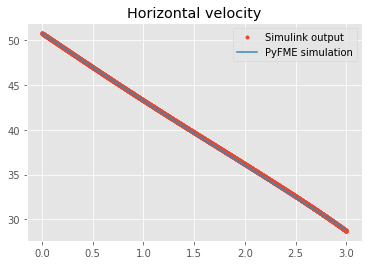

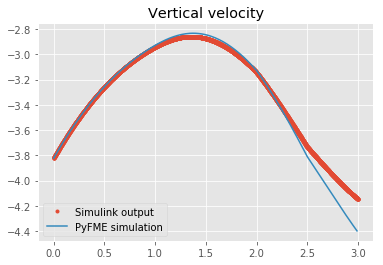

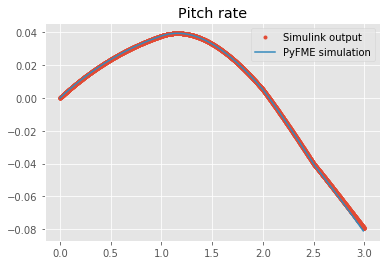

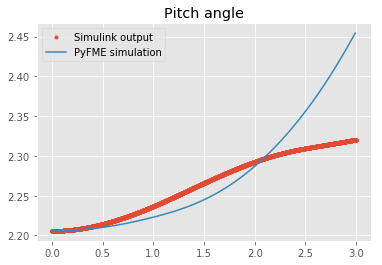

In [69]:
# Longitudinal values
plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['V_body'][:,0], '.', label='Simulink output')
plt.plot(results[case_id].u, label='PyFME simulation')
plt.legend()
plt.title("Horizontal velocity")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['V_body'][:,2], '.', label='Simulink output')
plt.plot(results[case_id].w, label='PyFME simulation')
plt.legend()
plt.title("Vertical velocity")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Omega_body'][:,1], '.', label='Simulink output')
plt.plot(results[case_id].q, label='PyFME simulation')
plt.legend()
plt.title("Pitch rate")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Euler'][:,1], '.', label='Simulink output')
plt.plot(results[case_id].theta, label='PyFME simulation')
plt.legend()
plt.title("Pitch angle")
plt.show()

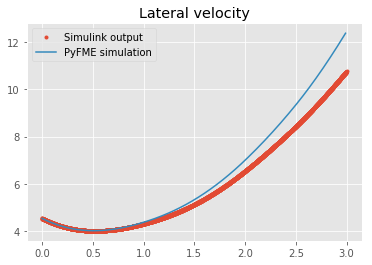

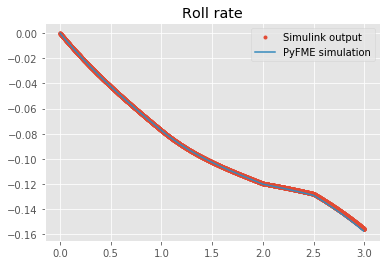

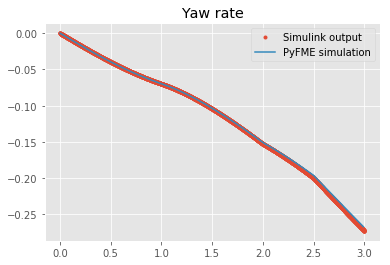

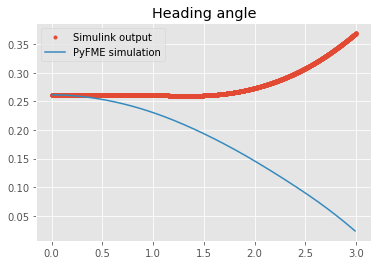

In [70]:
# Lateral case
plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['V_body'][:,1], '.', label='Simulink output')
plt.plot(results[case_id].v, label='PyFME simulation')
plt.legend()
plt.title("Lateral velocity")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Omega_body'][:,0], '.', label='Simulink output')
plt.plot(results[case_id].p, label='PyFME simulation')
plt.legend()
plt.title("Roll rate")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Omega_body'][:,2], '.', label='Simulink output')
plt.plot(results[case_id].r, label='PyFME simulation')
plt.legend()
plt.title("Yaw rate")
plt.show()

plt.plot(matlab_rslt[case_id]['t'], matlab_rslt[case_id]['Euler'][:,0], '.', label='Simulink output')
plt.plot(results[case_id].phi, label='PyFME simulation')
plt.legend()
plt.title("Heading angle")
plt.show()